# Seq2Seq Language Translation model, character-level

### Rosie Nguyen

### 1. Build a Seq2Seq Language Translation model that can translate from English to Vietnamese, Character Level Model

(See Datasets: http://www.manythings.org/anki/ )

### Import Libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Input, Dense,Embedding
from keras.models import Model,load_model
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.models import model_from_json
import pickle as pkl
import numpy as np
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from tensorflow import keras

### Download the data

In [ ]:
!!curl -O http://www.manythings.org/anki/vie-eng.zip
!!unzip vie-eng.zip

["'unzip' is not recognized as an internal or external command,",
 'operable program or batch file.']

### Configuration

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "vie.txt"

### Prepare the data

In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 7558
Number of unique input tokens: 73
Number of unique output tokens: 162
Max sequence length for inputs: 182
Max sequence length for outputs: 163


### Build the model

In [ ]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 162)]  0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 337920      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  429056      input_2[0][0]                    
                                                                 lstm[0][1]                   

### Train the model

In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")

Epoch 1/100
95/95 [==============================] - 246s 3s/step - loss: 0.8446 - accuracy: 0.8399 - val_loss: 1.3008 - val_accuracy: 0.7403
Epoch 2/100
95/95 [==============================] - 290s 3s/step - loss: 0.6235 - accuracy: 0.8560 - val_loss: 1.0535 - val_accuracy: 0.7688
Epoch 3/100
95/95 [==============================] - 264s 3s/step - loss: 0.5464 - accuracy: 0.8756 - val_loss: 0.8580 - val_accuracy: 0.7867
Epoch 4/100
95/95 [==============================] - 299s 3s/step - loss: 0.4362 - accuracy: 0.8901 - val_loss: 0.7666 - val_accuracy: 0.8033
Epoch 5/100
95/95 [==============================] - 194s 2s/step - loss: 0.3811 - accuracy: 0.8977 - val_loss: 0.7027 - val_accuracy: 0.8100
Epoch 6/100
95/95 [==============================] - 149s 2s/step - loss: 0.3535 - accuracy: 0.9026 - val_loss: 0.6579 - val_accuracy: 0.8238
Epoch 7/100
95/95 [==============================] - 156s 2s/step - loss: 0.3355 - accuracy: 0.9067 - val_loss: 0.6466 - val_accuracy: 0.8207
Epoch 

INFO:tensorflow:Assets written to: s2s\assets


INFO:tensorflow:Assets written to: s2s\assets


### Plot result of accuracy

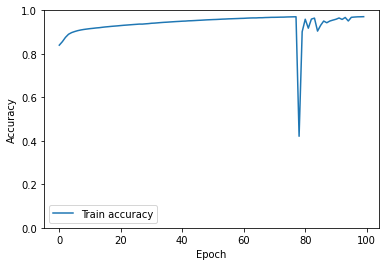

In [ ]:
def plot_history(history,key='acc'):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),
           label='Train accuracy')
  plt.legend()
  plt.ylim([0, 1])

plot_history(history)

### Plot result of loss

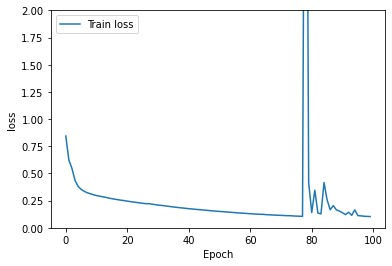

In [ ]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train loss')
  plt.legend()
  plt.ylim([0, 2])

plot_history(history)

**From the loss and accuracy plots, we should stop at epoch 70**

### Prediction using Character Level Model

**Run inference (sampling)**

In [ ]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

**Generate decoded sentences**

In [ ]:
for seq_index in [600]:
    # Take one sequence (part of the training set) for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)
    print("=="*50)

-
Input sentence: Where is the dog?
Decoded sentence: Chúng tôi đã không thể đến mười.



Because of the time limitation, I can only run the model for 100 epochs. 
The highest accuracy of the training model is about 84% for a model trained on 7558 dataset for 100 epochs. 
The limitation of the simple seq2seq language translation character level model is that in the generate decoded sentences, ithe translation is not good

### Scope of Improvement

Here are my suggestions:
- we can train the model on a large dataset with lots of variation in it.
- For lengthy Sentance limitation of it, we can include the Attention Mechanism.
- We can try replacing GRU with LSTM and check the performance of the model.